<a href="https://colab.research.google.com/github/tram-tr/predicting-molecular-properties/blob/main/models_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# need authorization code to mount drive
from google.colab import drive
drive.mount('/content/drive')
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/Colab Notebooks/Kaggle

Mounted at /content/drive
env: KAGGLE_CONFIG_DIR=/content/drive/My Drive/Colab Notebooks/Kaggle


In [2]:
!pip install kaggle
!kaggle competitions download -c champs-scalar-coupling
!pip install ase # visualize molecule

100% 375M/377M [00:12<00:00, 33.8MB/s]
100% 377M/377M [00:12<00:00, 31.8MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:00


In [3]:
!pip install openbabel-wheel
!pip install rdkit
!pip install hyperopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 45.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from collections import Counter, namedtuple
import scipy.sparse as sparse
from openbabel import pybel
from openbabel import openbabel
from scipy.sparse import csr_matrix
from typing import List
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import uniform, randint
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from xgboost import XGBRegressor
import lightgbm as lgb
import pickle
import time
from pprint import pprint

In [5]:
!unzip /content/champs-scalar-coupling.zip

Streaming output truncated to the last 5000 lines.
  inflating: structures/dsgdb9nsd_128302.xyz  
  inflating: structures/dsgdb9nsd_128303.xyz  
  inflating: structures/dsgdb9nsd_128304.xyz  
  inflating: structures/dsgdb9nsd_128305.xyz  
  inflating: structures/dsgdb9nsd_128306.xyz  
  inflating: structures/dsgdb9nsd_128308.xyz  
  inflating: structures/dsgdb9nsd_128309.xyz  
  inflating: structures/dsgdb9nsd_128310.xyz  
  inflating: structures/dsgdb9nsd_128311.xyz  
  inflating: structures/dsgdb9nsd_128312.xyz  
  inflating: structures/dsgdb9nsd_128313.xyz  
  inflating: structures/dsgdb9nsd_128314.xyz  
  inflating: structures/dsgdb9nsd_128315.xyz  
  inflating: structures/dsgdb9nsd_128316.xyz  
  inflating: structures/dsgdb9nsd_128317.xyz  
  inflating: structures/dsgdb9nsd_128318.xyz  
  inflating: structures/dsgdb9nsd_128319.xyz  
  inflating: structures/dsgdb9nsd_128320.xyz  
  inflating: structures/dsgdb9nsd_128321.xyz  
  inflating: structures/dsgdb9nsd_128322.xyz  
  inflati

In [6]:
train = pd.read_csv('drive/MyDrive/senior-yr/spring-2024/cse-60625/train_extend.csv')
test = pd.read_csv('drive/MyDrive/senior-yr/spring-2024/cse-60625/test_extend.csv')

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
test.shape

(2505190, 79)

In [9]:
train.shape

(4659076, 80)

In [10]:
def encode(df):
  encoding = {
    'H': 1,
    'C': 2,
    'N': 3,
    'O': 4,
    'F': 5,
    '': -1,
  }
  df['target_atom'] = df.target_atom.map(encoding)
  df['atom_2_symbol'] = df.atom_2_symbol.map(encoding)
  df['atom_3_symbol'] = df.atom_3_symbol.map(encoding)
  return df

In [11]:
train = encode(train)
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_bond,target_atom,n_bonds,min_d,mean_d,max_d,space_dist,bond_dist,bond_1,bond_2,bond_3,atom_0_pc,target_atom_pc,atom_0_fc,target_atom_fc,atom_0_val,target_atom_val,atom_0_sm,target_atom_sm,atom_0_symbol,atom_2_symbol,atom_3_symbol,target_atom_symbol,atom_0_hyb,atom_2_hyb,atom_3_hyb,target_atom_hyb,path_count,bond_angle,dihedral_angle,atom_0_min,atom_0_mean,atom_0_max,atom_0_Cmin,atom_0_Cmean,atom_0_Cmax,atom_0_Omin,atom_0_Omean,atom_0_Omax,atom_0_Nmin,atom_0_Nmean,atom_0_Nmax,atom_0_Fmin,atom_0_Fmean,atom_0_Fmax,target_atom_min,target_atom_mean,target_atom_max,target_atom_Cmin,target_atom_Cmean,target_atom_Cmax,target_atom_Omin,target_atom_Omean,target_atom_Omax,target_atom_Nmin,target_atom_Nmean,target_atom_Nmax,target_atom_Fmin,target_atom_Fmean,target_atom_Fmax,is_linear,center_dist_0,center_dist_1,num_C,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center,mulliken_charge_0,mulliken_charge_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,2,4,1.091946,1.506668,1.783158,1.091953,1.091953,1,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,H,NaN,NaN,C3,1,-1,-1,3,1,-1.000000,-1.0,1.091953,1.610344,1.783157,1.091953,1.091953,1.091953,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091945,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133921,-0.535689
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1,2,4,1.091946,1.506668,1.783158,1.091952,1.091952,1,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,H,NaN,NaN,C3,1,-1,-1,3,1,-1.000000,-1.0,1.091952,1.610344,1.783158,1.091952,1.091952,1.091952,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091946,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133922,-0.535689
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,1,2,4,1.091946,1.506668,1.783158,1.091946,1.091946,1,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,H,NaN,NaN,C3,1,-1,-1,3,1,-1.000000,-1.0,1.091946,1.610350,1.783158,1.091946,1.091946,1.091946,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091954,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133923,-0.535689
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,1,2,4,1.091946,1.506668,1.783158,1.091948,1.091948,1,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,H,NaN,NaN,C3,1,-1,-1,3,1,-1.000000,-1.0,1.091948,1.610350,1.783157,1.091948,1.091948,1.091948,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091954,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133923,-0.535689
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,2,1,4,1.091946,1.506668,1.783158,1.783120,2.183905,1,1,-1,0.019399,0.019399,0,0,1,1,0,0,H,NaN,NaN,H,1,3,-1,1,1,35.265769,-1.0,1.091953,1.610344,1.783157,1.091953,1.091953,1.091953,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091952,1.610344,1.783158,1.091952,1.091952,1.091952,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091945,1.091946,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133921,0.133922


In [12]:
test = encode(test)
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type,type_bond,target_atom,n_bonds,min_d,mean_d,max_d,space_dist,bond_dist,bond_1,bond_2,bond_3,atom_0_pc,target_atom_pc,atom_0_fc,target_atom_fc,atom_0_val,target_atom_val,atom_0_sm,target_atom_sm,atom_0_symbol,atom_2_symbol,atom_3_symbol,target_atom_symbol,atom_0_hyb,atom_2_hyb,atom_3_hyb,target_atom_hyb,path_count,bond_angle,dihedral_angle,atom_0_min,atom_0_mean,atom_0_max,atom_0_Cmin,atom_0_Cmean,atom_0_Cmax,atom_0_Omin,atom_0_Omean,atom_0_Omax,atom_0_Nmin,atom_0_Nmean,atom_0_Nmax,atom_0_Fmin,atom_0_Fmean,atom_0_Fmax,target_atom_min,target_atom_mean,target_atom_max,target_atom_Cmin,target_atom_Cmean,target_atom_Cmax,target_atom_Omin,target_atom_Omean,target_atom_Omax,target_atom_Nmin,target_atom_Nmean,target_atom_Nmax,target_atom_Fmin,target_atom_Fmean,target_atom_Fmax,center_dist_0,center_dist_1,num_C,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center,is_linear,mulliken_charge_0,mulliken_charge_1
0,4659076,dsgdb9nsd_000004,2,0,2JHC,2,2,3,1.062099,1.861485,3.323277,2.261178,2.261178,1,3,-1,0.122537,-0.122537,0,0,1,2,0,0,H,NaN,NaN,C1,1,1,-1,1,1,180.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0,0.175373,-0.382772
1,4659077,dsgdb9nsd_000004,2,1,1JHC,1,2,3,1.062099,1.861485,3.323277,1.062099,1.062099,1,-1,-1,0.122537,-0.122537,0,0,1,2,0,0,H,NaN,NaN,C1,1,-1,-1,1,1,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0,0.175373,-0.382772
2,4659078,dsgdb9nsd_000004,2,3,3JHH,3,1,3,1.062099,1.861485,3.323277,3.323277,3.323277,1,3,1,0.122537,0.122537,0,0,1,1,0,0,H,NaN,NaN,H,1,1,1,1,1,-1.0,NaN,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,1.661639,2,2,0,0,0,4,0.599539,1.130589,1.661639,0,0.175373,0.175373
3,4659079,dsgdb9nsd_000004,3,0,1JHC,1,2,3,1.062099,1.861485,3.323277,1.062099,1.062099,1,-1,-1,0.122537,-0.122537,0,0,1,2,0,0,H,NaN,NaN,C1,1,-1,-1,1,1,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0,0.175373,-0.382772
4,4659080,dsgdb9nsd_000004,3,1,2JHC,2,2,3,1.062099,1.861485,3.323277,2.261178,2.261178,1,3,-1,0.122537,-0.122537,0,0,1,2,0,0,H,NaN,NaN,C1,1,1,-1,1,1,180.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0,0.175373,-0.382772


In [13]:
train.shape

(4659076, 80)

In [14]:
test.shape

(2505190, 79)

In [15]:
train_pop_list = ['molecule_name', 'atom_index_0','atom_index_1', 'type_bond','bond_1', 'atom_0_symbol', 'target_atom_symbol']
test_pop_list = ['molecule_name', 'atom_index_0','atom_index_1', 'type_bond','bond_1', 'atom_0_symbol', 'target_atom_symbol']

train = train.drop(columns=train_pop_list)
test = test.drop(columns=test_pop_list)

In [16]:
train.fillna(value =-1, inplace= True)
test.fillna(value =-1, inplace= True)

In [17]:
types = sorted(train['type'].unique())
print(types)

['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN']


# **XGBoost**

In [ ]:
def xgb_model(X, y, j_type):
  train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)
  start_time = time.time()

  def objective(space):
      m = XGBRegressor(
          n_estimators=int(space['n_estimators']),
          max_depth=int(space['max_depth']),
          min_child_weight=space['min_child_weight'],
          gamma=space['gamma'],
          subsample=space['subsample'],
          colsample_bytree=space['colsample_bytree'],
          learning_rate=space['learning_rate'],
          reg_alpha=space['reg_alpha'],
          reg_lambda=space['reg_lambda'],
          tree_method='hist',
          device='cuda',
          booster='gbtree',
          eval_metric='mae',
          use_label_encoder=False,
          random_state=42
      )

      m.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=False)

      pred_y = m.predict(val_X)
      loss = mean_absolute_error(val_y, pred_y)
      return {'loss': loss, 'status': STATUS_OK}

  space = {
          'n_estimators': hp.quniform('n_estimators', 200, 2000, 100),
          'max_depth': hp.choice('max_depth', np.arange(5, 16, dtype=int)),
          'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1),
          'gamma': hp.quniform('gamma', 0, 10, 0.5),
          'subsample': hp.uniform('subsample', 0.5, 1),
          'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
          'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
          'reg_alpha': hp.quniform('reg_alpha', 0, 100, 1),
          'reg_lambda': hp.uniform('reg_lambda', 0, 1),
  }

  trials = Trials()
  best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
  best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
  best_hyperparams['max_depth'] = int(np.arange(5, 16, dtype=int)[best_hyperparams['max_depth']])
  best_hyperparams['min_child_weight'] = int(best_hyperparams['min_child_weight'])
  best_hyperparams['gamma'] = int(best_hyperparams['gamma'])
  best_hyperparams['reg_alpha'] = int(best_hyperparams['reg_alpha'])

  print('best hyperparameters:\n', best_hyperparams)

  final_m = XGBRegressor(**best_hyperparams, tree_method='hist', booster='gbtree', eval_metric='mae', use_label_encoder=False, random_state=42)
  final_m.fit(train_X, train_y)

  pred_train_y = final_m.predict(train_X)
  pred_val_y = final_m.predict(val_X)

  train_lmae = np.log(mean_absolute_error(train_y, pred_train_y))
  val_lmae = np.log(mean_absolute_error(val_y, pred_val_y))

  end_time = time.time()
  print(f'\ttrain log mae: {train_lmae}')
  print(f'\tval log mae: {val_lmae}')
  print(f'\ttotal time: {end_time - start_time} seconds')

  # saving the model
  with open(f'drive/MyDrive/senior-yr/spring-2024/cse-60625/xgb_{j_type}_model.pkl', 'wb') as file:
      pickle.dump(final_m, file)

  return train_lmae, val_lmae, val_y, pred_val_y

training model for type: 1JHC...
100%|██████████| 100/100 [38:59<00:00, 23.40s/trial, best loss: 0.9583985409776714]
best hyperparameters:
 {'colsample_bytree': 0.8239637435334779, 'gamma': 0, 'learning_rate': 0.08210058866483336, 'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 1900, 'reg_alpha': 14, 'reg_lambda': 0.12714853269137624, 'subsample': 0.5695749290973814}
	train log mae: -1.0080464523014376
	val log mae: -0.039796775788344146
	total time: 2608.0742948055267 seconds


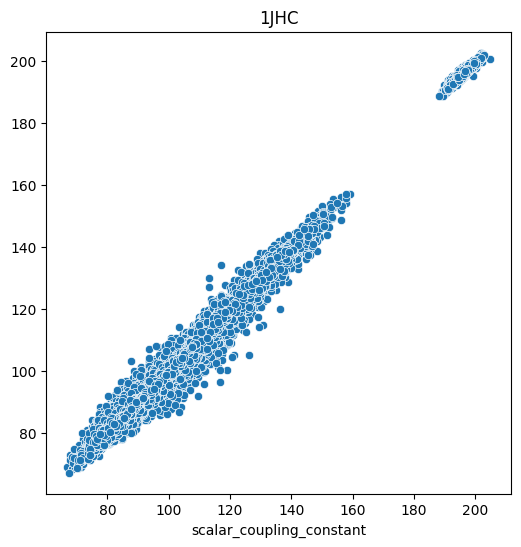

training model for type: 1JHN...
100%|██████████| 100/100 [07:10<00:00,  4.31s/trial, best loss: 0.41009640296998917]
best hyperparameters:
 {'colsample_bytree': 0.5861277106451697, 'gamma': 0, 'learning_rate': 0.048282171158341596, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 1500, 'reg_alpha': 5, 'reg_lambda': 0.4073680167632176, 'subsample': 0.7337482447140905}
	train log mae: -2.1910943317832343
	val log mae: -0.8842409676356453
	total time: 459.06407356262207 seconds


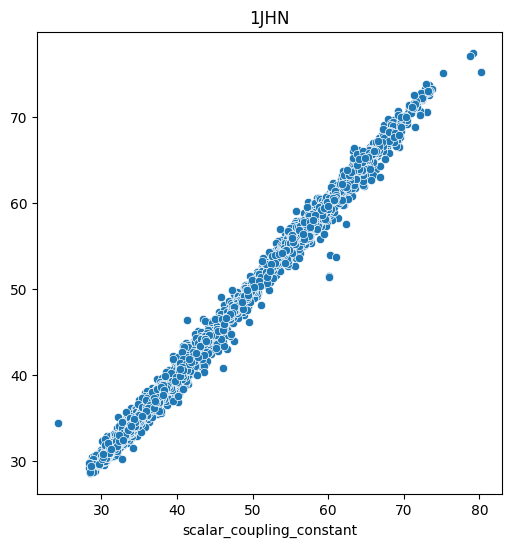

training model for type: 2JHC...
100%|██████████| 100/100 [44:52<00:00, 26.92s/trial, best loss: 0.3765690138256463]
best hyperparameters:
 {'colsample_bytree': 0.8357049478855396, 'gamma': 0, 'learning_rate': 0.0740758179775489, 'max_depth': 14, 'min_child_weight': 6, 'n_estimators': 1800, 'reg_alpha': 38, 'reg_lambda': 0.5849247464881487, 'subsample': 0.8813029485030989}
	train log mae: -1.5151495157788377
	val log mae: -0.9750307853821216
	total time: 3128.8629262447357 seconds


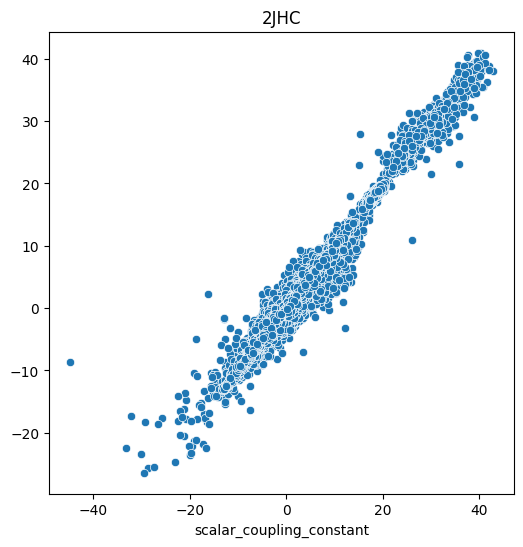

training model for type: 2JHH...
100%|██████████| 100/100 [16:22<00:00,  9.83s/trial, best loss: 0.20392812617924574]
best hyperparameters:
 {'colsample_bytree': 0.7173270309599248, 'gamma': 0, 'learning_rate': 0.04777726816567664, 'max_depth': 14, 'min_child_weight': 18, 'n_estimators': 1100, 'reg_alpha': 0, 'reg_lambda': 0.25055576914499655, 'subsample': 0.657168168674396}
	train log mae: -2.8276934437999275
	val log mae: -1.5837167225886977
	total time: 1091.9566450119019 seconds


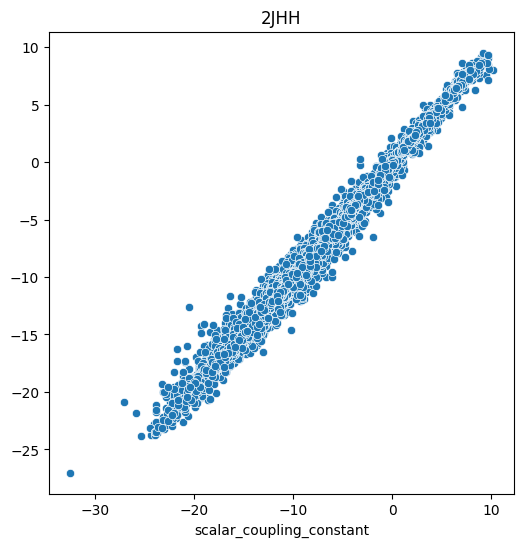

training model for type: 2JHN...
100%|██████████| 100/100 [08:31<00:00,  5.11s/trial, best loss: 0.2492294677852568]
best hyperparameters:
 {'colsample_bytree': 0.904702604051052, 'gamma': 0, 'learning_rate': 0.14242771175572183, 'max_depth': 15, 'min_child_weight': 8, 'n_estimators': 1100, 'reg_alpha': 0, 'reg_lambda': 0.6932181379077207, 'subsample': 0.9843564581682327}
	train log mae: -7.322252896765863
	val log mae: -1.3938548607874865
	total time: 583.230384349823 seconds


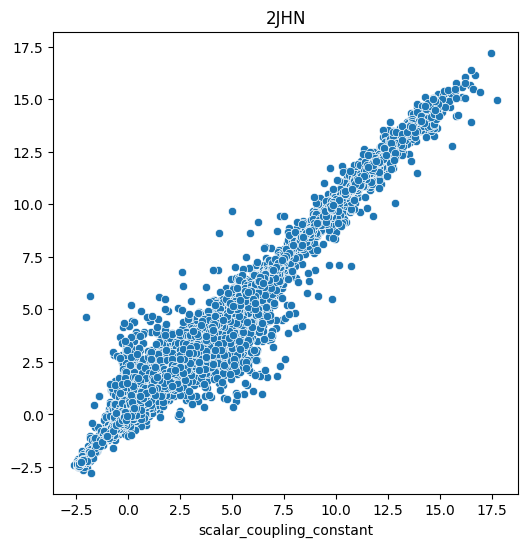

training model for type: 3JHC...
100%|██████████| 100/100 [1:02:51<00:00, 37.71s/trial, best loss: 0.4334757375833413]
best hyperparameters:
 {'colsample_bytree': 0.973186473356893, 'gamma': 0, 'learning_rate': 0.07656383739767929, 'max_depth': 13, 'min_child_weight': 19, 'n_estimators': 2000, 'reg_alpha': 49, 'reg_lambda': 0.7154568001697227, 'subsample': 0.9123580092751381}
	train log mae: -1.303082000926023
	val log mae: -0.8380989552422531
	total time: 4321.892295837402 seconds


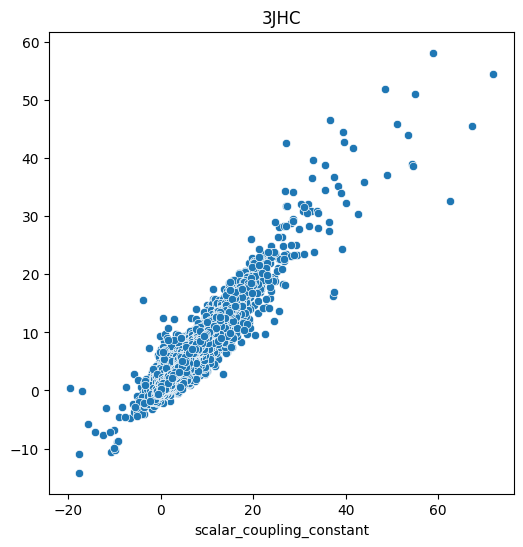

training model for type: 3JHH...
100%|██████████| 100/100 [24:07<00:00, 14.47s/trial, best loss: 0.24892552051333522]
best hyperparameters:
 {'colsample_bytree': 0.9879414924832187, 'gamma': 0, 'learning_rate': 0.06102054665266199, 'max_depth': 13, 'min_child_weight': 7, 'n_estimators': 1500, 'reg_alpha': 15, 'reg_lambda': 0.29392523710018337, 'subsample': 0.9930546526613466}
	train log mae: -2.0942013154852166
	val log mae: -1.3882316667362709
	total time: 1683.5547292232513 seconds


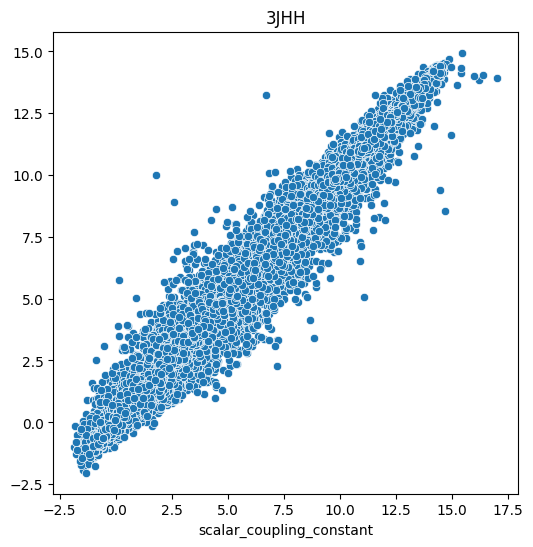

training model for type: 3JHN...
100%|██████████| 100/100 [11:41<00:00,  7.01s/trial, best loss: 0.18876697923864288]
best hyperparameters:
 {'colsample_bytree': 0.8716484715012374, 'gamma': 0, 'learning_rate': 0.016219817735764107, 'max_depth': 10, 'min_child_weight': 9, 'n_estimators': 1400, 'reg_alpha': 0, 'reg_lambda': 0.22771905494416628, 'subsample': 0.8858698409523772}
	train log mae: -2.241327213247021
	val log mae: -1.66721484032927
	total time: 762.7900156974792 seconds


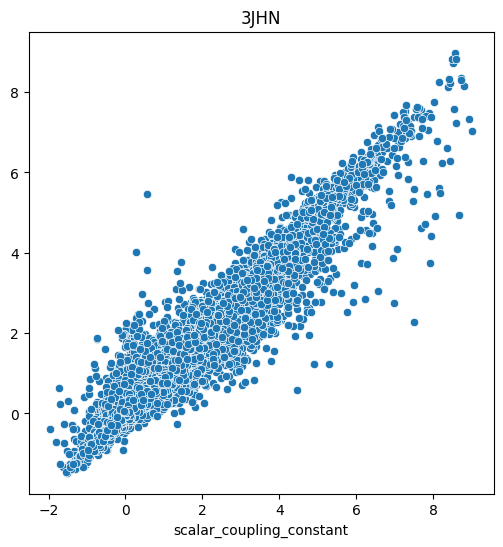

In [ ]:
xgb_val_lmae, xgb_train_lmae, xgb_val_y, xgb_val_pred_y = {}, {}, {}, {}


for j_type in types:
  X = train[train['type'] == j_type].drop(columns=['scalar_coupling_constant', 'type'])
  y = train[train['type'] == j_type]['scalar_coupling_constant']
  print(f'training model for type: {j_type}...')
  xgb_train_lmae[j_type], xgb_val_lmae[j_type], xgb_val_y[j_type], xgb_val_pred_y[j_type] = xgb_model(X, y, j_type)

  plt.figure(figsize=[6,6])
  sns.scatterplot(x=xgb_val_y[j_type], y=xgb_val_pred_y[j_type])
  plt.title(j_type)
  plt.show()

In [ ]:
pprint(xgb_val_lmae)
pprint(xgb_train_lmae)

{'1JHC': -0.039796775788344146,
 '1JHN': -0.8842409676356453,
 '2JHC': -0.9750307853821216,
 '2JHH': -1.5837167225886977,
 '2JHN': -1.3938548607874865,
 '3JHC': -0.8380989552422531,
 '3JHH': -1.3882316667362709,
 '3JHN': -1.66721484032927}
{'1JHC': -1.0080464523014376,
 '1JHN': -2.1910943317832343,
 '2JHC': -1.5151495157788377,
 '2JHH': -2.8276934437999275,
 '2JHN': -7.322252896765863,
 '3JHC': -1.303082000926023,
 '3JHH': -2.0942013154852166,
 '3JHN': -2.241327213247021}


In [18]:
train_X, val_X, train_y, val_y = train_test_split(train.drop(columns=['scalar_coupling_constant']), train[['id', 'type', 'scalar_coupling_constant']], test_size=0.2, random_state=42)

In [19]:
val_X.head()

,id,type,target_atom,n_bonds,min_d,mean_d,max_d,space_dist,bond_dist,bond_2,bond_3,atom_0_pc,target_atom_pc,atom_0_fc,target_atom_fc,atom_0_val,target_atom_val,atom_0_sm,target_atom_sm,atom_2_symbol,atom_3_symbol,atom_0_hyb,atom_2_hyb,atom_3_hyb,target_atom_hyb,path_count,bond_angle,dihedral_angle,atom_0_min,atom_0_mean,atom_0_max,atom_0_Cmin,atom_0_Cmean,atom_0_Cmax,atom_0_Omin,atom_0_Omean,atom_0_Omax,atom_0_Nmin,atom_0_Nmean,atom_0_Nmax,atom_0_Fmin,atom_0_Fmean,atom_0_Fmax,target_atom_min,target_atom_mean,target_atom_max,target_atom_Cmin,target_atom_Cmean,target_atom_Cmax,target_atom_Omin,target_atom_Omean,target_atom_Omax,target_atom_Nmin,target_atom_Nmean,target_atom_Nmax,target_atom_Fmin,target_atom_Fmean,target_atom_Fmax,is_linear,center_dist_0,center_dist_1,num_C,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center,mulliken_charge_0,mulliken_charge_1
1021770,1021762,2JHC,2,17,1.082357,2.813804,5.698614,2.312215,2.632618,1,-1,0.062543,0.057317,0,0,1,4,0,0,-1.0,-1.0,1,3,-1,3,1,178.583226,-1.000000,1.087972,3.097912,5.127322,1.087972,2.737788,4.187946,2.049682,2.049682,2.049682,3.126723,4.127023,5.127322,-1.0,-1.0,-1.0,1.082357,2.439447,4.661228,1.470608,2.233041,3.609763,2.384688,2.384688,2.384688,1.511005,3.086116,4.661228,-1.0,-1.0,-1.0,0,2.398915,1.475916,6,6,2,1,0,15,1.193917,1.953713,3.243617,0.102293,-0.064048
3077385,3077431,3JHC,2,22,1.017539,3.096412,5.998619,2.545519,4.018386,1,1,0.123246,-0.026279,0,0,1,4,0,0,-1.0,-1.0,1,3,3,3,3,-1.000000,52.758246,1.017539,3.307620,4.645704,2.068329,2.854739,4.048267,3.728254,3.728254,3.728254,1.017539,1.017539,1.017539,-1.0,-1.0,-1.0,1.093453,2.682879,4.311996,1.541128,2.345612,3.394234,3.660065,3.660065,3.660065,2.502406,2.502406,2.502406,-1.0,-1.0,-1.0,0,2.486084,1.568274,7,11,1,1,0,20,0.864142,2.185720,3.114471,0.229183,-0.315119
147756,147762,1JHC,2,15,1.016143,3.066678,7.037918,1.092724,1.092724,-1,-1,0.025708,-0.034717,0,0,1,4,0,0,-1.0,-1.0,1,-1,-1,3,1,-1.000000,-1.000000,1.092724,3.031088,4.505291,1.092724,2.619636,3.605699,-1.000000,-1.000000,-1.000000,3.398972,3.738074,4.077176,-1.0,-1.0,-1.0,1.092429,2.619373,4.518473,1.538469,2.615470,3.526148,-1.000000,-1.000000,-1.000000,2.440618,3.092333,3.744048,-1.0,-1.0,-1.0,0,2.110908,1.535461,6,8,2,0,0,16,0.214159,2.097867,3.821743,0.129877,-0.404267
4396169,4396174,1JHC,2,18,1.093576,3.565121,7.901722,1.110222,1.110222,-1,-1,0.103420,0.132395,0,0,1,3,0,0,-1.0,-1.0,1,-1,-1,2,1,-1.000000,-1.000000,1.110222,3.457473,5.468118,1.110222,2.930261,4.533765,2.023690,2.943795,4.078586,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,1.110222,3.376601,6.008896,1.529109,3.152040,5.003498,1.203009,2.531756,3.492749,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,0,2.279833,2.335660,6,10,0,3,0,19,0.751739,2.522813,4.033382,0.103805,0.151332
2996626,2996602,3JHH,1,22,1.084107,3.277669,6.581775,3.106445,3.693497,1,1,0.032674,0.029650,0,0,1,1,0,0,-1.0,-1.0,1,3,3,1,2,-1.000000,51.708658,1.086932,3.360122,5.559747,1.086932,2.800837,4.623521,2.502126,3.598641,4.695156,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,1.086083,3.183639,4.930225,1.086083,2.681024,3.925618,3.413683,3.887296,4.360908,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,0,2.460968,2.133685,7,12,0,2,0,21,0.352871,2.309792,3.597005,0.098391,0.106320


In [20]:
xgb_1JHC = pickle.load(open('drive/MyDrive/senior-yr/spring-2024/cse-60625/xgb_1JHC_model.pkl', 'rb'))
xgb_1JHN = pickle.load(open('drive/MyDrive/senior-yr/spring-2024/cse-60625/xgb_1JHN_model.pkl', 'rb'))
xgb_2JHC = pickle.load(open('drive/MyDrive/senior-yr/spring-2024/cse-60625/xgb_2JHC_model.pkl', 'rb'))
xgb_2JHH = pickle.load(open('drive/MyDrive/senior-yr/spring-2024/cse-60625/xgb_2JHH_model.pkl', 'rb'))
xgb_2JHN = pickle.load(open('drive/MyDrive/senior-yr/spring-2024/cse-60625/xgb_2JHN_model.pkl', 'rb'))
xgb_3JHC = pickle.load(open('drive/MyDrive/senior-yr/spring-2024/cse-60625/xgb_3JHC_model.pkl', 'rb'))
xgb_3JHH = pickle.load(open('drive/MyDrive/senior-yr/spring-2024/cse-60625/xgb_3JHC_model.pkl', 'rb'))
xgb_3JHN = pickle.load(open('drive/MyDrive/senior-yr/spring-2024/cse-60625/xgb_3JHN_model.pkl', 'rb'))

In [21]:
val_X_1JHC = val_X[val_X['type'] == '1JHC']
val_y_1JHC = val_y[val_y['type'] == '1JHC'].copy()
val_y_1JHC['pred'] = xgb_1JHC.predict(val_X_1JHC.drop(columns=['id', 'type']))
val_1JHC_lmae = np.log(mean_absolute_error(val_y_1JHC['scalar_coupling_constant'], val_y_1JHC['pred']))
print(val_1JHC_lmae)

-0.7269393193999976


In [22]:
val_X_1JHN = val_X[val_X['type'] == '1JHN']
val_y_1JHN = val_y[val_y['type'] == '1JHN'].copy()
val_y_1JHN['pred'] = xgb_1JHN.predict(val_X_1JHN.drop(columns=['id', 'type']))
val_1JHN_lmae = np.log(mean_absolute_error(val_y_1JHN['scalar_coupling_constant'], val_y_1JHN['pred']))
print(val_1JHN_lmae)

-1.775108225465845


In [23]:
val_X_2JHC = val_X[val_X['type'] == '2JHC']
val_y_2JHC = val_y[val_y['type'] == '2JHC'].copy()
val_y_2JHC['pred'] = xgb_2JHC.predict(val_X_2JHC.drop(columns=['id', 'type']))
val_2JHC_lmae = np.log(mean_absolute_error(val_y_2JHC['scalar_coupling_constant'], val_y_2JHC['pred']))
print(val_2JHC_lmae)

-1.3805749430987257


In [24]:
val_X_2JHH = val_X[val_X['type'] == '2JHH']
val_y_2JHH = val_y[val_y['type'] == '2JHH'].copy()
val_y_2JHH['pred'] = xgb_2JHH.predict(val_X_2JHH.drop(columns=['id', 'type']))
val_2JHH_lmae = np.log(mean_absolute_error(val_y_2JHH['scalar_coupling_constant'], val_y_2JHH['pred']))
print(val_2JHH_lmae)

-2.4344063328519283


In [25]:
val_X_2JHN = val_X[val_X['type'] == '2JHN']
val_y_2JHN = val_y[val_y['type'] == '2JHN'].copy()
val_y_2JHN['pred'] = xgb_2JHN.predict(val_X_2JHN.drop(columns=['id', 'type']))
val_2JHN_lmae = np.log(mean_absolute_error(val_y_2JHN['scalar_coupling_constant'], val_y_2JHN['pred']))
print(val_2JHN_lmae)

-2.9559904806150517


In [26]:
val_X_3JHC = val_X[val_X['type'] == '3JHC']
val_y_3JHC = val_y[val_y['type'] == '3JHC'].copy()
val_y_3JHC['pred'] = xgb_3JHC.predict(val_X_3JHC.drop(columns=['id', 'type']))
val_3JHC_lmae = np.log(mean_absolute_error(val_y_3JHC['scalar_coupling_constant'], val_y_3JHC['pred']))
print(val_3JHC_lmae)

-1.1934713868254048


In [27]:
val_X_3JHH = val_X[val_X['type'] == '3JHH']
val_y_3JHH = val_y[val_y['type'] == '3JHH'].copy()
val_y_3JHH['pred'] = xgb_3JHH.predict(val_X_3JHH.drop(columns=['id', 'type']))
val_3JHH_lmae = np.log(mean_absolute_error(val_y_3JHH['scalar_coupling_constant'], val_y_3JHH['pred']))
print(val_3JHH_lmae)

1.2840118260858155


In [28]:
val_X_3JHN = val_X[val_X['type'] == '3JHN']
val_y_3JHN = val_y[val_y['type'] == '3JHN'].copy()
val_y_3JHN['pred'] = xgb_3JHN.predict(val_X_3JHN.drop(columns=['id', 'type']))
val_3JHN_lmae = np.log(mean_absolute_error(val_y_3JHN['scalar_coupling_constant'], val_y_3JHN['pred']))
print(val_3JHN_lmae)

-2.0958848053151407


In [29]:
groups = val_X['type']

def group_lmae(y_true, y_pred, groups, floor=1e-9):
  maes = (y_true - y_pred).abs().groupby(groups).mean()
  return np.log(maes.map(lambda x: max(x, floor))).mean()

In [30]:
val_pred = pd.concat([val_y_1JHC, val_y_1JHN, val_y_2JHC, val_y_2JHH, val_y_2JHN, val_y_3JHC, val_y_3JHH, val_y_3JHN])

In [31]:
val_pred.sort_values(by='id')

,id,type,scalar_coupling_constant,pred
0,0,1JHC,84.807600,84.915611
8,6,2JHH,-11.254800,-11.263671
2,7,1JHC,84.809300,84.915611
13,11,2JHH,-11.186600,-11.432889
15,14,2JHH,-11.175800,-11.432889
...,...,...,...,...
4659034,4659055,2JHC,-1.148660,-1.252806
4659043,4659056,3JHC,6.131220,6.070859
4659059,4659062,3JHC,-0.244777,0.043879
4659044,4659065,1JHC,99.657200,99.526726


In [32]:
y_true = val_pred['scalar_coupling_constant']
y_pred = val_pred['pred']

In [33]:
y_pred

147756      82.036324
4396169    120.013466
3639798     84.456474
500400      97.543671
236279     117.407066
              ...    
3042356     -0.023418
3790793      1.765795
1203543      0.120424
2231059      0.613543
1065108      0.882781
Name: pred, Length: 931816, dtype: float32

In [34]:
group_lmae(y_true, y_pred, groups)

-1.4097954584357848

In [35]:
val_lmae = (val_1JHC_lmae + val_1JHN_lmae + val_2JHC_lmae + val_2JHH_lmae + val_2JHN_lmae + val_3JHC_lmae + val_3JHH_lmae + val_3JHN_lmae)/8
print(val_lmae)

-1.4097954584357846


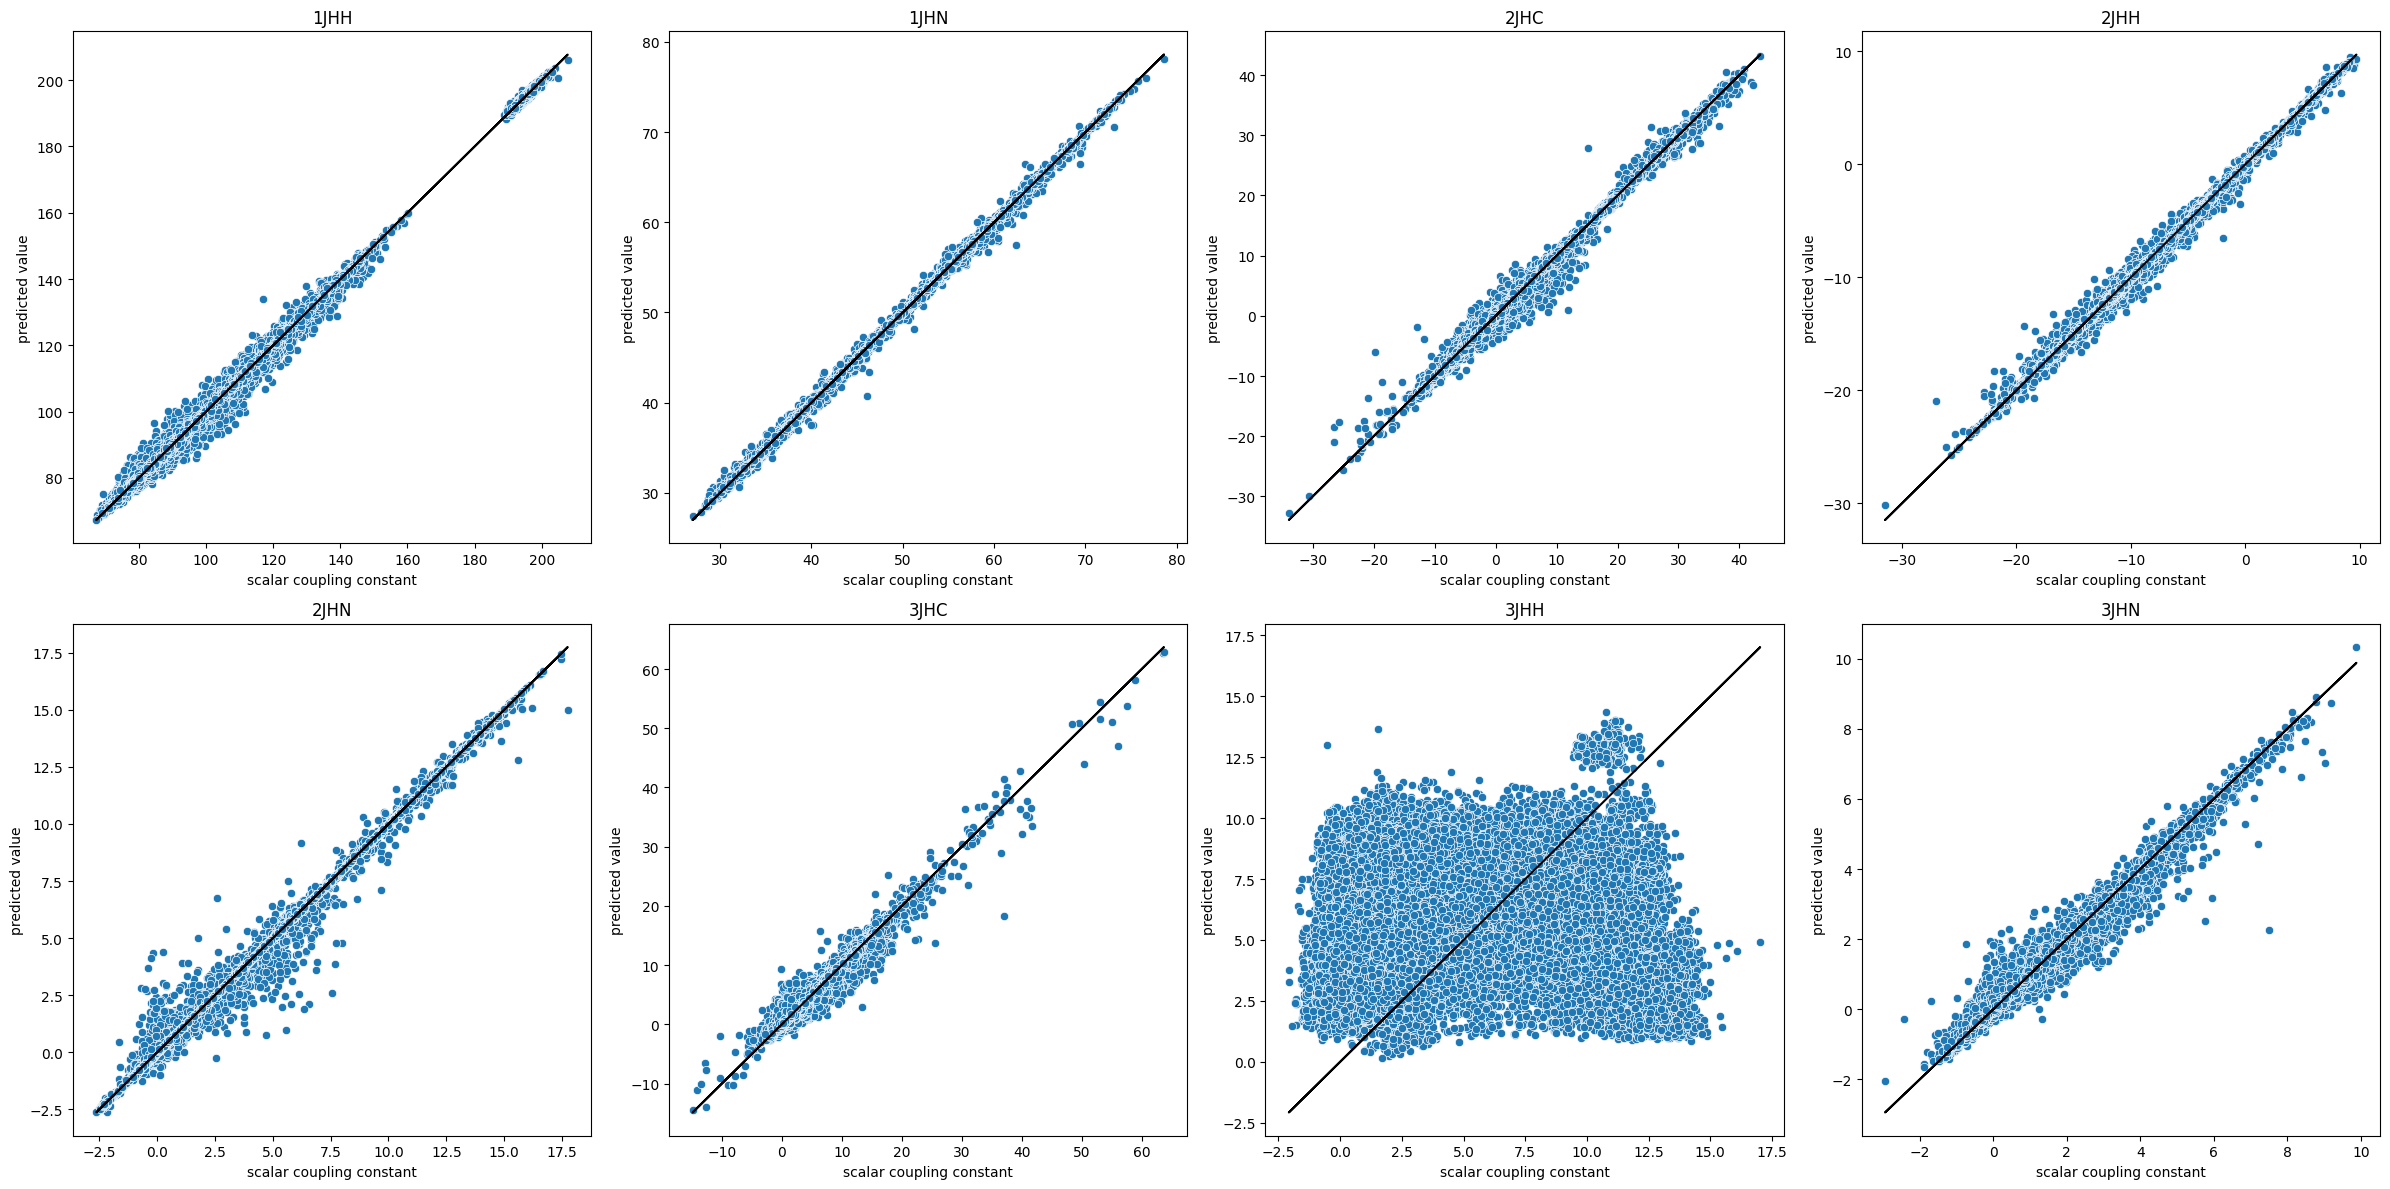

In [36]:
data = {
    '1JHH': val_y_1JHC,
    '1JHN': val_y_1JHN,
    '2JHC': val_y_2JHC,
    '2JHH': val_y_2JHH,
    '2JHN': val_y_2JHN,
    '3JHC': val_y_3JHC,
    '3JHH': val_y_3JHH,
    '3JHN': val_y_3JHN,
}


fig, axes = plt.subplots(2, 4, figsize=(24, 12))

for idx, (title, df) in enumerate(data.items()):
    ax = axes[idx // 4, idx % 4]
    sns.scatterplot(ax=ax, x=df['scalar_coupling_constant'], y=df['pred'])
    ax.plot(df['scalar_coupling_constant'], df['scalar_coupling_constant'], color='black')
    ax.set_title(title)
    ax.set_xlabel('scalar coupling constant')
    ax.set_ylabel('predicted value')

plt.tight_layout()

plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/plotting.py:130: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xlim)


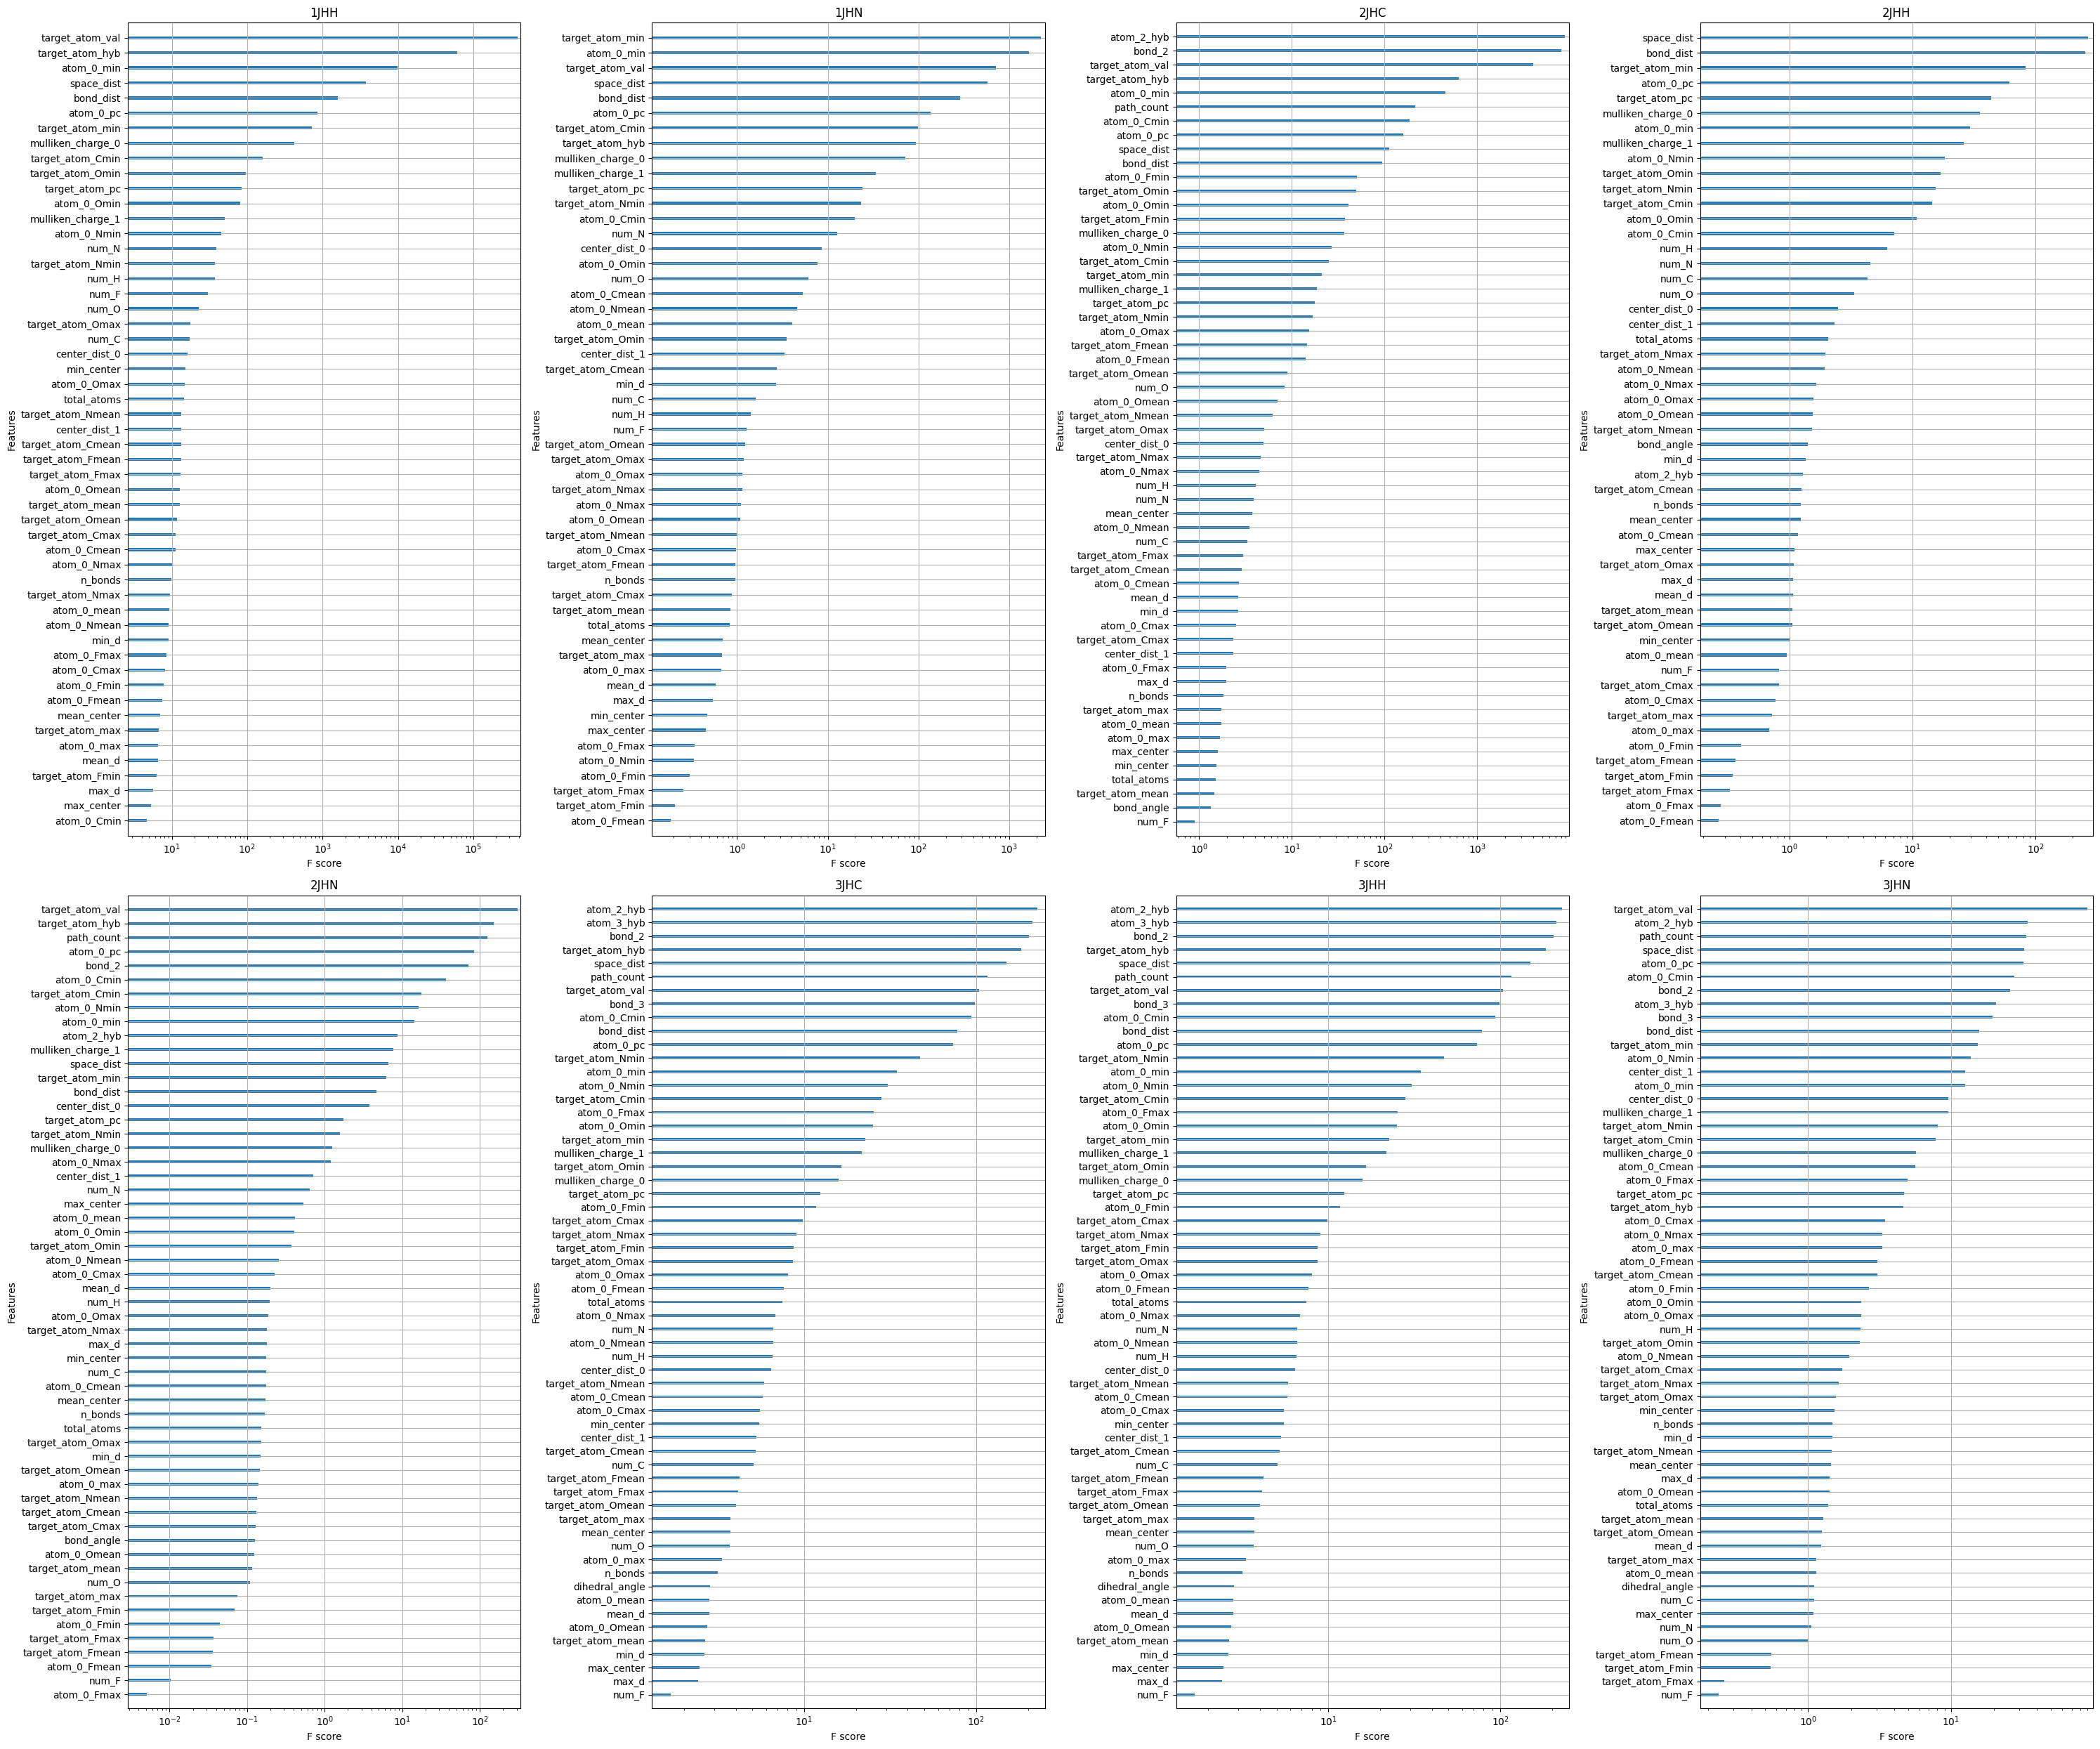

In [37]:
import xgboost
models = {
    '1JHH': xgb_1JHC,
    '1JHN': xgb_1JHN,
    '2JHC': xgb_2JHC,
    '2JHH': xgb_2JHH,
    '2JHN': xgb_2JHN,
    '3JHC': xgb_3JHC,
    '3JHH': xgb_3JHH,
    '3JHN': xgb_3JHN
}


fig, axes = plt.subplots(2, 4, figsize=(30, 25))

for idx, (title, model) in enumerate(models.items()):
    ax = axes[idx // 4, idx % 4]  #
    xgboost.plot_importance(model, importance_type='gain', ax=ax, show_values=False, log=True)
    ax.title.set_text(title)

plt.tight_layout()


plt.show()

In [ ]:
test.head()

,id,type,target_atom,n_bonds,min_d,mean_d,max_d,space_dist,bond_dist,bond_2,bond_3,atom_0_pc,target_atom_pc,atom_0_fc,target_atom_fc,atom_0_val,target_atom_val,atom_0_sm,target_atom_sm,atom_2_symbol,atom_3_symbol,atom_0_hyb,atom_2_hyb,atom_3_hyb,target_atom_hyb,path_count,bond_angle,dihedral_angle,atom_0_min,atom_0_mean,atom_0_max,atom_0_Cmin,atom_0_Cmean,atom_0_Cmax,atom_0_Omin,atom_0_Omean,atom_0_Omax,atom_0_Nmin,atom_0_Nmean,atom_0_Nmax,atom_0_Fmin,atom_0_Fmean,atom_0_Fmax,target_atom_min,target_atom_mean,target_atom_max,target_atom_Cmin,target_atom_Cmean,target_atom_Cmax,target_atom_Omin,target_atom_Omean,target_atom_Omax,target_atom_Nmin,target_atom_Nmean,target_atom_Nmax,target_atom_Fmin,target_atom_Fmean,target_atom_Fmax,center_dist_0,center_dist_1,num_C,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center,mulliken_charge_0
0,4659076,2JHC,2,3,1.062099,1.861485,3.323277,2.261178,2.261178,3,-1,0.122537,-0.122537,0,0,1,2,0,0,-1.0,-1.0,1,1,-1,1,1,180.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373
1,4659077,1JHC,2,3,1.062099,1.861485,3.323277,1.062099,1.062099,-1,-1,0.122537,-0.122537,0,0,1,2,0,0,-1.0,-1.0,1,-1,-1,1,1,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373
2,4659078,3JHH,1,3,1.062099,1.861485,3.323277,3.323277,3.323277,3,1,0.122537,0.122537,0,0,1,1,0,0,-1.0,-1.0,1,1,1,1,1,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,1.661639,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373
3,4659079,1JHC,2,3,1.062099,1.861485,3.323277,1.062099,1.062099,-1,-1,0.122537,-0.122537,0,0,1,2,0,0,-1.0,-1.0,1,-1,-1,1,1,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373
4,4659080,2JHC,2,3,1.062099,1.861485,3.323277,2.261178,2.261178,3,-1,0.122537,-0.122537,0,0,1,2,0,0,-1.0,-1.0,1,1,-1,1,1,180.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373


In [ ]:
test = test[train.drop(columns=['scalar_coupling_constant']).columns]

In [ ]:
test_1JHC = test[test['type'] == '1JHC'].copy()
pred_1JHC = xgb_1JHC.predict(test_1JHC.drop(columns=['id', 'type']))
test_1JHC['scalar_coupling_constant'] = pred_1JHC

In [ ]:
test_1JHN = test[test['type'] == '1JHN'].copy()
pred_1JHN = xgb_1JHN.predict(test_1JHN.drop(columns=['id', 'type']))
test_1JHN['scalar_coupling_constant'] = pred_1JHN

In [ ]:
test_2JHC = test[test['type'] == '2JHC'].copy()
pred_2JHC = xgb_2JHC.predict(test_2JHC.drop(columns=['id', 'type']))
test_2JHC['scalar_coupling_constant'] = pred_2JHC

In [ ]:
test_2JHH = test[test['type'] == '2JHH'].copy()
pred_2JHH = xgb_2JHH.predict(test_2JHH.drop(columns=['id', 'type']))
test_2JHH['scalar_coupling_constant'] = pred_2JHH

In [ ]:
test_2JHN = test[test['type'] == '2JHN'].copy()
pred_2JHN = xgb_2JHN.predict(test_2JHN.drop(columns=['id', 'type']))
test_2JHN['scalar_coupling_constant'] = pred_2JHN

In [ ]:
test_3JHC = test[test['type'] == '3JHC'].copy()
pred_3JHC = xgb_3JHC.predict(test_3JHC.drop(columns=['id', 'type']))
test_3JHC['scalar_coupling_constant'] = pred_3JHC

In [ ]:
test_3JHH = test[test['type'] == '3JHH'].copy()
pred_3JHH = xgb_3JHH.predict(test_3JHH.drop(columns=['id', 'type']))
test_3JHH['scalar_coupling_constant'] = pred_3JHH

In [ ]:
test_3JHN = test[test['type'] == '3JHN'].copy()
pred_3JHN = xgb_3JHN.predict(test_3JHN.drop(columns=['id', 'type']))
test_3JHN['scalar_coupling_constant'] = pred_3JHN

In [ ]:
test_pred = pd.concat([test_1JHC, test_1JHN, test_2JHC, test_2JHH, test_2JHN, test_3JHC, test_3JHH, test_3JHN])

In [ ]:
test_pred = test_pred.sort_values(by='id')

In [ ]:
test_pred.head()

,id,type,target_atom,n_bonds,min_d,mean_d,max_d,space_dist,bond_dist,bond_2,bond_3,atom_0_pc,target_atom_pc,atom_0_fc,target_atom_fc,atom_0_val,target_atom_val,atom_0_sm,target_atom_sm,atom_2_symbol,atom_3_symbol,atom_0_hyb,atom_2_hyb,atom_3_hyb,target_atom_hyb,path_count,bond_angle,dihedral_angle,atom_0_min,atom_0_mean,atom_0_max,atom_0_Cmin,atom_0_Cmean,atom_0_Cmax,atom_0_Omin,atom_0_Omean,atom_0_Omax,atom_0_Nmin,atom_0_Nmean,atom_0_Nmax,atom_0_Fmin,atom_0_Fmean,atom_0_Fmax,target_atom_min,target_atom_mean,target_atom_max,target_atom_Cmin,target_atom_Cmean,target_atom_Cmax,target_atom_Omin,target_atom_Omean,target_atom_Omax,target_atom_Nmin,target_atom_Nmean,target_atom_Nmax,target_atom_Fmin,target_atom_Fmean,target_atom_Fmax,is_linear,center_dist_0,center_dist_1,num_C,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center,mulliken_charge_0,mulliken_charge_1,scalar_coupling_constant
0,4659076,2JHC,2,3,1.062099,1.861485,3.323277,2.261178,2.261178,3,-1,0.122537,-0.122537,0,0,1,2,0,0,-1.0,-1.0,1,1,-1,1,1,180.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,-0.382772,17.363195
1,4659077,1JHC,2,3,1.062099,1.861485,3.323277,1.062099,1.062099,-1,-1,0.122537,-0.122537,0,0,1,2,0,0,-1.0,-1.0,1,-1,-1,1,1,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,-0.382772,189.847000
2,4659078,3JHH,1,3,1.062099,1.861485,3.323277,3.323277,3.323277,3,1,0.122537,0.122537,0,0,1,1,0,0,-1.0,-1.0,1,1,1,1,1,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.661639,1.661639,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,0.175373,4.718609
3,4659079,1JHC,2,3,1.062099,1.861485,3.323277,1.062099,1.062099,-1,-1,0.122537,-0.122537,0,0,1,2,0,0,-1.0,-1.0,1,-1,-1,1,1,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,-0.382772,189.847000
4,4659080,2JHC,2,3,1.062099,1.861485,3.323277,2.261178,2.261178,3,-1,0.122537,-0.122537,0,0,1,2,0,0,-1.0,-1.0,1,1,-1,1,1,180.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,-0.382772,17.363195


In [ ]:
sub = pd.DataFrame(data={
    'id': test_pred['id'],
    'scalar_coupling_constant': test_pred['scalar_coupling_constant']
})

In [ ]:
sample = pd.read_csv('sample_submission.csv')
sample.shape

(2505190, 2)